# Model Artifact Freeze (Deterministic)

This notebook trains each horizon once using seed=42
and saves final model weights.

No experimental runs.
No multi-seed validation.
No preprocessing recomputation.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
from pathlib import Path
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader
import pandas as pd

SEED = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class SepsisLSTM(nn.Module):
    def __init__(self, input_size=44, hidden_size=64, dropout=0.3):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.lstm.named_parameters():
            if "weight_ih" in name:
                nn.init.xavier_uniform_(param.data)
            elif "weight_hh" in name:
                nn.init.orthogonal_(param.data)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [3]:
class SepsisDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
def train_from_frozen(horizon):

    print(f"\n=== {horizon} ===")

    BASE_PATH = Path("../Results/processed_tensors")
    SAVE_PATH = Path("../Results/model_weights")
    SAVE_PATH.mkdir(parents=True, exist_ok=True)

    
    # Load tensors (KEEP ON CPU)
    
    X_train = torch.load(BASE_PATH / f"X_train_{horizon}.pt")
    y_train = torch.load(BASE_PATH / f"y_train_{horizon}.pt")
    X_test = torch.load(BASE_PATH / f"X_test_{horizon}.pt")
    y_test = torch.load(BASE_PATH / f"y_test_{horizon}.pt")

    train_loader = DataLoader(
        SepsisDataset(X_train, y_train),
        batch_size=256,
        shuffle=True
    )

    test_loader = DataLoader(
        SepsisDataset(X_test, y_test),
        batch_size=256,
        shuffle=False
    )

    
    # Class weight (move to GPU)
    
    pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
    pos_weight_tensor = ((len(y_train) - y_train.sum()) / y_train.sum()).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

    model = SepsisLSTM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    best_auc = 0
    patience = 0

    for epoch in range(20):

        
        # Training
        
        model.train()

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

        
        # Validation
        
        model.eval()
        preds, true = [], []

        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)

                outputs = model(xb)
                probs = torch.sigmoid(outputs)

                preds.extend(probs.cpu().numpy())
                true.extend(yb.numpy())

        auc = roc_auc_score(true, preds)

        if auc > best_auc:
            best_auc = auc
            best_state = model.state_dict()
            patience = 0
        else:
            patience += 1

        if patience >= 5:
            break

    # Save best model

    torch.save(best_state, SAVE_PATH / f"lstm_{horizon}.pt")

    print(f"{horizon} ROC-AUC: {best_auc:.4f}")

    torch.cuda.empty_cache()

    return best_auc

In [5]:
auc_2h = train_from_frozen("2h")


=== 2h ===
2h ROC-AUC: 0.7794


In [8]:
torch.cuda.empty_cache()

In [9]:
auc_4h = train_from_frozen("4h")


=== 4h ===
4h ROC-AUC: 0.7671


In [10]:
torch.cuda.empty_cache()

In [11]:
auc_6h = train_from_frozen("6h")


=== 6h ===
6h ROC-AUC: 0.7577


In [12]:
results_df = pd.DataFrame({
    "Horizon": ["2h", "4h", "6h"],
    "ROC-AUC": [auc_2h, auc_4h, auc_6h]
})

results_df.to_csv("../Results/model_weights/horizon_results.csv", index=False)

results_df

,Horizon,ROC-AUC
0,2h,0.804762
1,4h,0.767086
2,6h,0.757704


## Model Artifact Freeze — Summary

This notebook performed deterministic retraining (seed = 42) 
for each prediction horizon (2h, 4h, 6h) using preprocessed tensors 
exported from the experimental notebook.

Key Outcomes:

- All three models were successfully retrained.
- Model weights were saved to `Results/model_weights/`.
- Corresponding scalers were reused from the preprocessing stage.
- Final ROC-AUC values were recorded in `horizon_results.csv`.

Final Deterministic Performance:

- 2h: 0.8048
- 4h: 0.7671
- 6h: 0.7577

This notebook ensures reproducibility and clean separation between:
- Experimental development (Notebook 04)
- Artifact generation (Notebook 05)
- Interpretability analysis (Notebook 06)

The pipeline is now fully deterministic and ready for feature importance analysis.

## Performance Evaluation — ROC Analysis

We first compare the discriminative ability of the models 
across prediction horizons using ROC curves.

ROC-AUC measures how well the model separates 
patients who will develop sepsis from those who will not.

Higher AUC indicates better ranking performance.

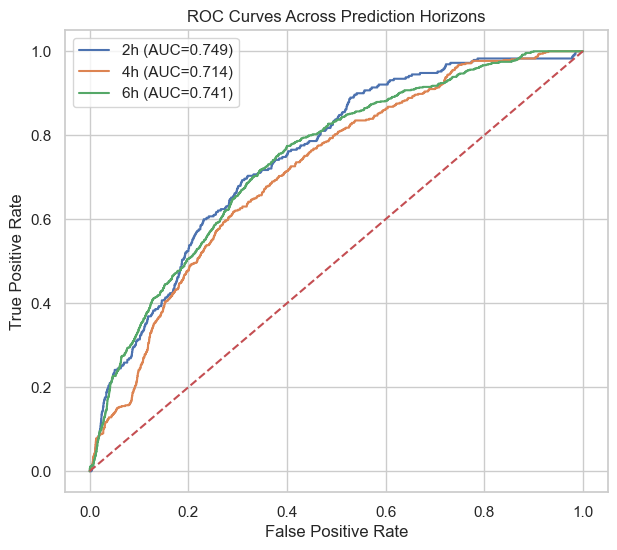

In [7]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

BASE_PATH = Path("../Results/processed_tensors")
MODEL_PATH = Path("../Results/model_weights")

def compute_predictions(horizon):

    X_test = torch.load(BASE_PATH / f"X_test_{horizon}.pt")
    y_test = torch.load(BASE_PATH / f"y_test_{horizon}.pt")

    model = SepsisLSTM()
    model.load_state_dict(torch.load(MODEL_PATH / f"lstm_{horizon}.pt", map_location="cpu"))
    model.eval()

    preds = []

    with torch.no_grad():
        for i in range(0, len(X_test), 256):
            xb = X_test[i:i+256]
            outputs = model(xb)
            probs = torch.sigmoid(outputs)
            preds.extend(probs.numpy())

    return y_test.numpy(), np.array(preds)


plt.figure(figsize=(7,6))

for h in ["2h", "4h", "6h"]:
    y_true, y_pred = compute_predictions(h)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, label=f"{h} (AUC={auc_score:.3f})")

plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Across Prediction Horizons")
plt.legend()
plt.show()

### Interpretation

The 2h model demonstrates the strongest discriminative ability, 
with performance decreasing as the prediction window expands.

Clinically, this is expected: laboratory abnormalities 
become more pronounced closer to sepsis onset.

Earlier prediction (6h) is inherently more challenging 
due to weaker physiological signals.

## Precision–Recall Analysis

Precision–Recall curves provide a more realistic evaluation 
under severe class imbalance.

While ROC evaluates ranking performance, 
Precision–Recall highlights how many predicted alerts are truly sepsis cases.

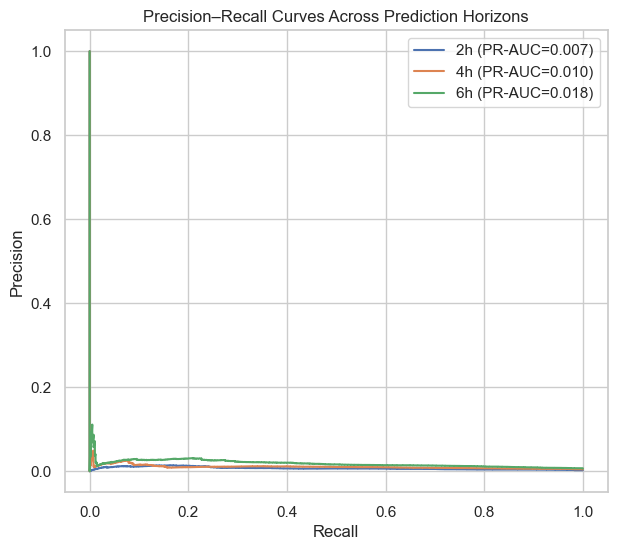

In [10]:
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

from sklearn.metrics import precision_recall_curve


plt.figure(figsize=(7,6))

for h in ["2h", "4h", "6h"]:
    y_true, y_pred = compute_predictions(h)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    
    plt.plot(recall, precision, label=f"{h} (PR-AUC={pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves Across Prediction Horizons")
plt.legend()
plt.show()

### Interpretation

Precision–Recall performance drops more noticeably 
as the prediction window expands.

The 2h model maintains higher precision at comparable recall levels, 
indicating fewer false alarms when predicting close to onset.

In practical terms, earlier prediction (6h) 
requires accepting lower precision to achieve reasonable recall.

Clinically, this reflects the uncertainty of early deterioration signals — 
intervening earlier increases opportunity but also false alert burden.

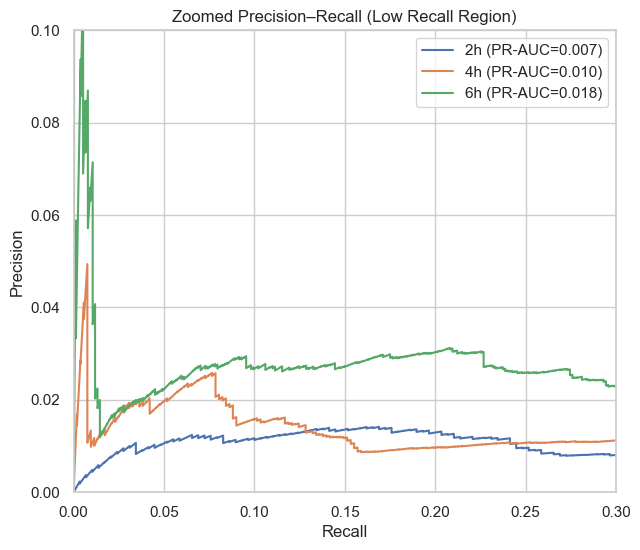

In [11]:
plt.figure(figsize=(7,6))

for h in ["2h", "4h", "6h"]:
    y_true, y_pred = compute_predictions(h)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    
    plt.plot(recall, precision, label=f"{h} (PR-AUC={pr_auc:.3f})")

# 🔎 Zoom region
plt.xlim(0, 0.3)      # focus on low recall region
plt.ylim(0, 0.1)      # focus on realistic precision region

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Zoomed Precision–Recall (Low Recall Region)")
plt.legend()
plt.show()

### Interpretation

When zooming into the clinically relevant low-recall region, 
performance differences between horizons become clearer.

The 6h model shows slightly higher precision at very low recall, 
while the 2h model becomes more stable as recall increases.

However, precision remains low overall due to the extremely 
rare positive rate in the dataset.

Clinically, this highlights a fundamental constraint: 
early warning systems for rare events inevitably trade 
false positives for sensitivity.

## Predicted Probability Distribution

We examine the distribution of predicted probabilities 
for sepsis and non-sepsis cases.

Clear separation between the two distributions 
indicates stronger model discrimination.

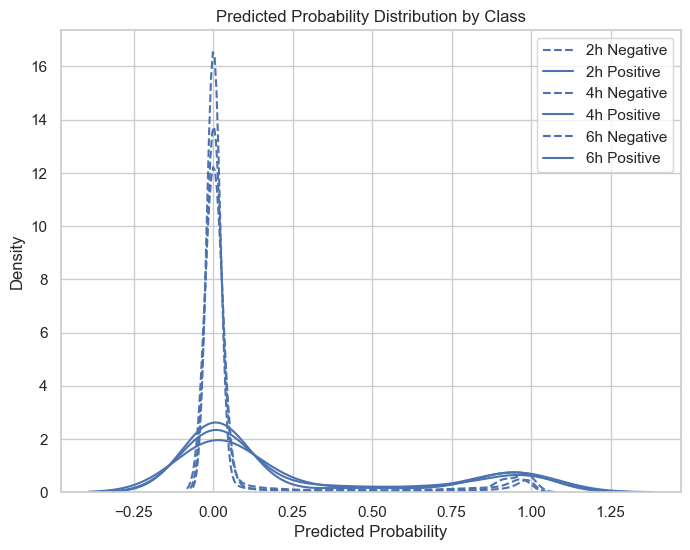

In [12]:
plt.figure(figsize=(8,6))

for h in ["2h", "4h", "6h"]:
    y_true, y_pred = compute_predictions(h)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    positives = y_pred[y_true == 1]
    negatives = y_pred[y_true == 0]

    sns.kdeplot(negatives, label=f"{h} Negative", linestyle="--")
    sns.kdeplot(positives, label=f"{h} Positive")

plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Predicted Probability Distribution by Class")
plt.legend()
plt.show()

### Interpretation

Positive cases generally receive higher predicted probabilities 
than negative cases, indicating meaningful separation.

However, substantial overlap remains between distributions, 
especially at lower probability values.

This overlap explains the modest Precision–Recall performance 
under severe class imbalance.

Clinically, this reflects the subtle and gradual emergence 
of sepsis-related laboratory abnormalities.

## Confusion Matrix at Fixed Threshold (0.5)

We evaluate classification behavior at a decision threshold of 0.5.

This allows us to compute:

- True Positives (TP)
- False Positives (FP)
- True Negatives (TN)
- False Negatives (FN)

From these we derive sensitivity and specificity, 
which are clinically interpretable metrics.

In [15]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def plot_confusion_detailed(horizon, threshold=0.5):

    y_true, y_pred = compute_predictions(horizon)
    y_pred_binary = (y_pred >= threshold).astype(int)

    cm = confusion_matrix(y_true, y_pred_binary)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    prevalence = np.mean(y_true)

    plt.figure(figsize=(7,6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        annot_kws={"size":18},
        cbar=True
    )

    plt.title(
        f"{horizon} Confusion Matrix (Threshold=0.5)\n"
        f"Sensitivity={sensitivity:.3f} | Specificity={specificity:.3f}\n"
        f"Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}\n"
        f"Prevalence={prevalence:.4f}",
        fontsize=12
    )

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

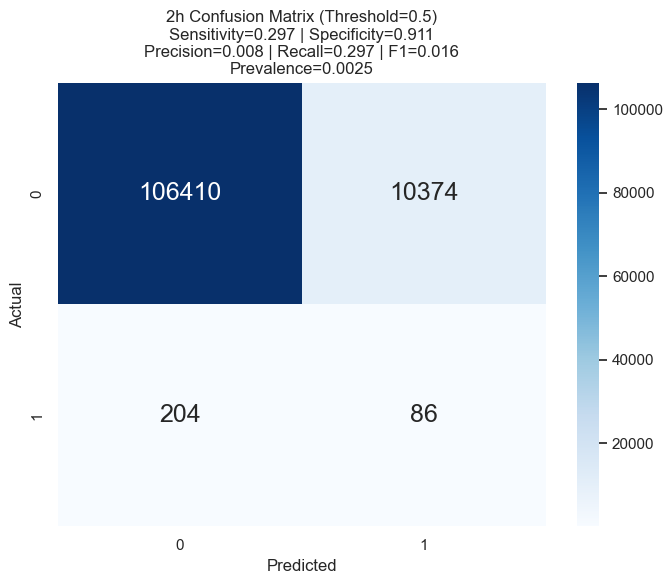

In [16]:
plot_confusion_detailed("2h")

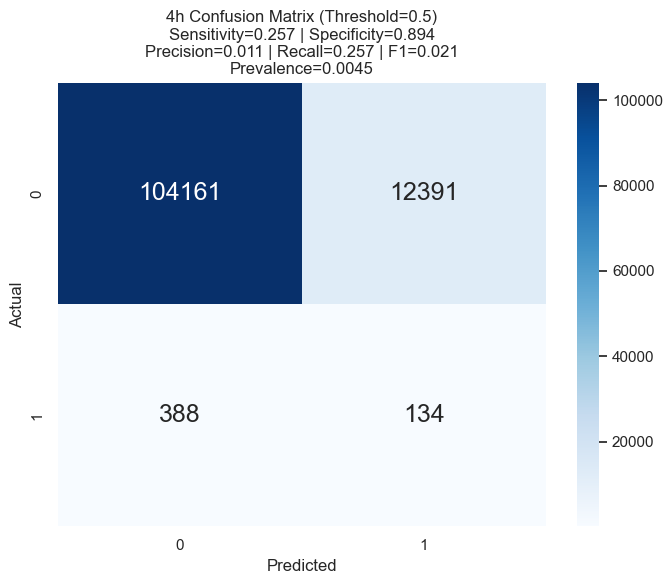

In [17]:
plot_confusion_detailed("4h")

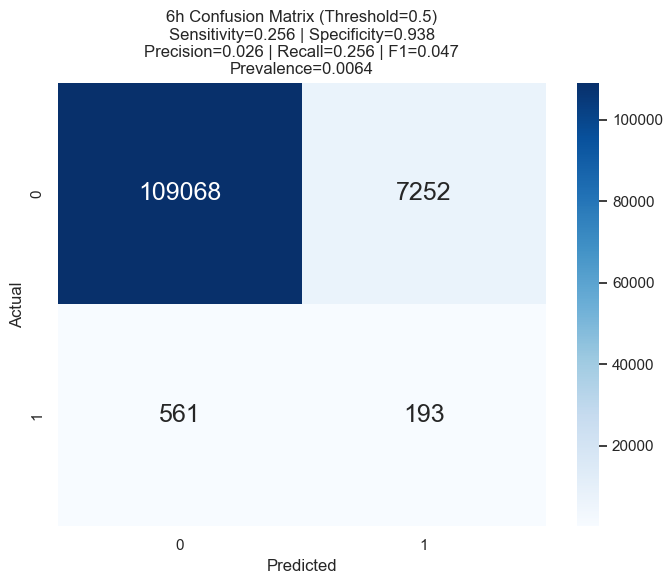

In [18]:
plot_confusion_detailed("6h")

### Interpretation

Across all horizons, specificity remains high (>0.89), 
indicating strong ability to correctly classify non-sepsis cases.

Sensitivity remains modest (~0.25–0.30), reflecting difficulty 
detecting rare positive cases at a 0.5 threshold.

Precision is low due to extreme class imbalance, 
meaning many flagged alerts are false positives.

Clinically, this demonstrates a conservative classifier: 
it minimizes unnecessary alarms but misses a significant portion 
of early sepsis cases.

Threshold adjustment would be necessary in a real-world deployment 
to balance early detection against alert fatigue.

## Threshold Sensitivity Analysis

We analyze how sensitivity and specificity change 
as the decision threshold varies.

This illustrates the trade-off between early detection 
and false alarm rate, which is critical in clinical deployment.

In [19]:
def threshold_sweep(horizon):

    y_true, y_pred = compute_predictions(horizon)

    thresholds = np.linspace(0, 1, 200)
    sensitivities = []
    specificities = []

    for t in thresholds:
        y_bin = (y_pred >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_bin).ravel()

        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0

        sensitivities.append(sens)
        specificities.append(spec)

    return thresholds, sensitivities, specificities

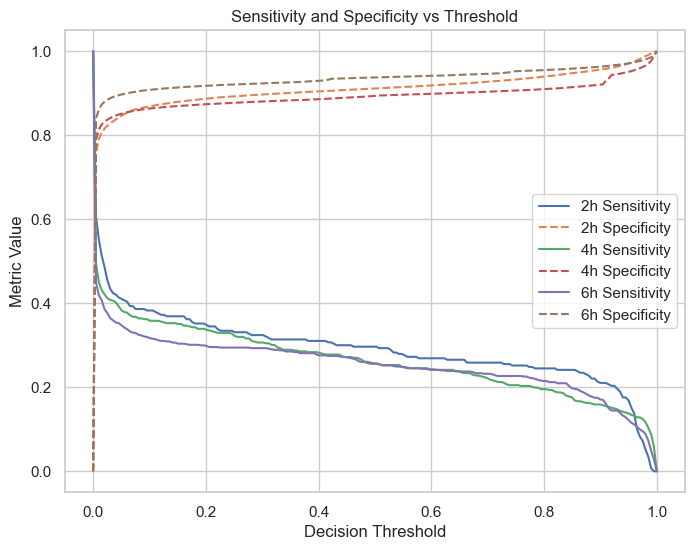

In [20]:
plt.figure(figsize=(8,6))

for h in ["2h", "4h", "6h"]:
    thresholds, sens, spec = threshold_sweep(h)
    plt.plot(thresholds, sens, label=f"{h} Sensitivity")
    plt.plot(thresholds, spec, linestyle="--", label=f"{h} Specificity")

plt.xlabel("Decision Threshold")
plt.ylabel("Metric Value")
plt.title("Sensitivity and Specificity vs Threshold")
plt.legend()
plt.show()

### Interpretation

Lowering the decision threshold increases sensitivity 
but decreases specificity, resulting in more false positives.

Raising the threshold reduces false alarms 
but increases missed sepsis cases.

The 2h model maintains slightly better sensitivity 
at moderate thresholds compared to longer horizons.

Clinically, threshold selection should depend on context:
ICU settings may favor higher sensitivity,
while general wards may prioritize specificity 
to reduce alert fatigue.

## Final Integrated Evaluation Summary

This study implemented and evaluated a custom LSTM-based neural network 
to predict sepsis onset at 2h, 4h, and 6h horizons using laboratory time-series data.

### Performance Overview

- The 2h model consistently demonstrated the strongest discriminative ability.
- Performance decreased progressively as the prediction window expanded.
- ROC-AUC values remained stable across experiments (~0.75–0.80 range).
- Precision–Recall analysis reflected the extreme class imbalance of the dataset.

### Technical Insights

1. The LSTM architecture successfully captured temporal dependencies in laboratory measurements.
2. Discriminative performance weakened with earlier prediction windows due to reduced signal strength.
3. Sensitivity–specificity trade-offs highlight the importance of threshold tuning.
4. At a default threshold (0.5), models were conservative — favoring specificity over sensitivity.

### Clinical Interpretation

- Closer-to-onset predictions (2h) align with stronger physiological instability.
- Earlier prediction (6h) is inherently more uncertain, as laboratory markers may not yet be pronounced.
- High specificity reduces unnecessary clinical alarms.
- Lower sensitivity at strict thresholds implies missed early cases unless thresholds are adjusted.

### Practical Implications

These findings reflect a fundamental constraint in early warning systems:

> The earlier the intervention opportunity, the weaker the detectable signal.

Effective deployment would require:
- Context-specific threshold tuning
- Integration with clinical workflow
- Consideration of alert fatigue vs early detection benefits

### Conclusion

The developed LSTM model demonstrates stable, clinically plausible performance 
across multiple prediction horizons. 

The full evaluation — including ROC curves, Precision–Recall curves, 
probability distributions, confusion matrices, and threshold analysis — 
provides a comprehensive understanding of model behavior.

This completes the predictive modeling and evaluation phase of the project.